In [1]:
import re
from collections import OrderedDict

def load_sequences(seqfile):
        seqs = OrderedDict()
        fp = open(seqfile, "rb")
        print("#Loading " + seqfile + " ...")
        expecting = "label"
        label=''
        for line in fp:
                if expecting == "label":
                        match = re.match(">(.*)$", line)
                        if match:
                                label = match.group(1)
                                expecting = "sequence"
                        else:
                                print("Expecting LABEL but found (!!): " + line)
                                continue
                else:
                        match = re.match("(\w+)$", line)
                        if match:
                                sequence = match.group(1)
                                seqs[label]=sequence
                        else:
                                print("Expecting SEQUENCE but found (!!): " + line)
                        expecting = "label"
                        label=''
        fp.close()
        print("#Loaded " + str(len(seqs.keys())) + " sequences from " + seqfile)
        return seqs

In [2]:
pos_seqs_dict= load_sequences('/users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.fa')
neg_seqs_dict= load_sequences('/users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.fa')
#pos_seqs_dict= load_sequences('/users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.summits.fa')
#neg_seqs_dict= load_sequences('/users/eprakash/projects/benchmarking/newdata/GM12878/400bp/GM12878.400bp.neg.summits.fa')
pos_labels=pos_seqs_dict.keys()
neg_labels=neg_seqs_dict.keys()
pos_seqs=pos_seqs_dict.values()
neg_seqs=neg_seqs_dict.values()

#Loading /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.fa ...
#Loaded 143217 sequences from /users/eprakash/projects/benchmarking/newdata/A549/A549.summits.400bp.fa
#Loading /users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.fa ...
#Loaded 1033975 sequences from /users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.fa


In [3]:
def gc_content(seq):
    g_count=seq.lower().count('g')
    c_count=seq.lower().count('c')
    return float(g_count+c_count)/float(len(seq))

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def sample_matched_bqtls(bqtls_to_match, bqtls_to_sample, attrfunc):
    #sort bqtls_to_sample by the attribute
    sorted_bqtls_to_sample = sorted([x for x in bqtls_to_sample
                                     if np.isnan(attrfunc(x))==False],
                                    key=lambda x: attrfunc(x))
    #create a list of just the attribute values from the sorted items
    sorted_bqtls_to_sample_vals = [attrfunc(x) for x in sorted_bqtls_to_sample]
    
    bqtls_to_match_vals = [attrfunc(x) for x in bqtls_to_match]

    #for each value in the set to match, find the index in sorted_bqtls_to_sample_vals that matches it best
    searchsorted_indices = np.searchsorted(a=sorted_bqtls_to_sample_vals, v=bqtls_to_match_vals)
    
    matched_sampled_bqtls_indices = set()
    
    for idx in searchsorted_indices:
        #if the index you are considering sampling has already been sampled in a previous step, shift the index around until you find an index that isn't taken
        shift = 1
        while (idx in matched_sampled_bqtls_indices or idx==len(sorted_bqtls_to_sample)):
            #if you are about to go over the end of the list in your search for an index that is not taken, start searching in the other direction
            if idx == len(sorted_bqtls_to_sample):
                shift = -1
            idx += shift
        if (idx < 0 or idx > len(sorted_bqtls_to_sample)):
            print(idx) #this print statement shouldn't be triggered unless the set you are trying to match is bigger than the set you are subsampling from
        matched_sampled_bqtls_indices.add(idx)
    
    matched_sampled_bqtls = [sorted_bqtls_to_sample[idx] for idx in sorted(matched_sampled_bqtls_indices)]
    
    #compare the two distributions to see if they match well
    import seaborn as sns
    sns.distplot([attrfunc(x) for x in bqtls_to_match], color='blue')
    sns.distplot([attrfunc(x) for x in matched_sampled_bqtls], color='red')
    plt.show()
    
    return matched_sampled_bqtls

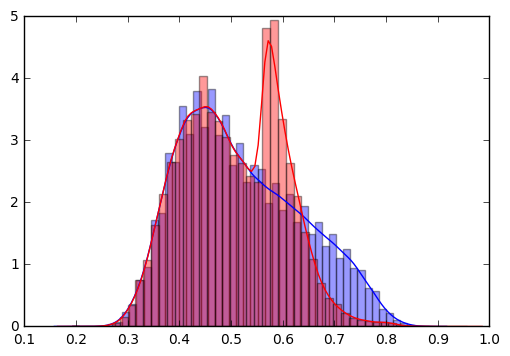

In [5]:
matched_sampled_negatives=sample_matched_bqtls(bqtls_to_match=pos_seqs, bqtls_to_sample=neg_seqs, attrfunc=gc_content)

In [6]:
matched_neg_seqs=OrderedDict()
for matched_seq in matched_sampled_negatives:
    idx=neg_seqs.index(matched_seq)
    matched_neg_seqs.update({neg_labels[idx]:neg_seqs[idx]})

In [7]:
fp = open('/users/eprakash/projects/benchmarking/newdata/A549/no_A549_universal_dnase.matched.fa', "w")
#fp = open('universal_dnase.matched.GM12878.summits.400bp.hg38.fa', "w")
idx=0
for matched_seq_key in matched_neg_seqs.keys():
    fp.write('>'+matched_seq_key+'\n')
    if idx==len(matched_neg_seqs)-1:
        fp.write(matched_neg_seqs[matched_seq_key])
    else:
        fp.write(matched_neg_seqs[matched_seq_key]+'\n')
fp.close()